# Texi demand prediction in New York City

In [2]:
# importing libraries

# pip3 install graphviz
# pip3 install desk
# pip3 install toolz
# pip3 install cloudpickle
# pip3 install graphviz

import dask.dataframe as dd     # Similar to pandas
import pandas as pd             # Pandas to create small dataframes

# pip3 install folium
# if this doesnot work refer install_folium.JPG in drive

import folium                   # open street map

# unix time : https://www.unixtimestamp.com/
import datetime                 # convert to unix time
import time                     # convert to unix time

import numpy as np              # To preform airtmetic operation on arrays 
import matplotlib               # used to plot graph

matplotlib.use('nbagg')         # matplotlib uses this protocall which makes plots more user interactive 

import matplotlib.pyplot as plt
import seaborn as sns           # Plots
from matplotlib import rcParams # size of the plot

# this library is used while we calculate the stight line distance between two (lat, lon) pairs in matrix
import gpxpy.geo                # get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans  # clustring 
import math
import pickle
import os

# download migwin : https://mingw.w64.org/doku.php/download/mingw-builds
# install this in your system and keep the path as migw_path = 'Installed path'
# mingw_path = ''
# os.inviron['PATH'] = mingw_path + ';' + os.inviron['PATH']

import os
os.environ['PATH'] += os.pathsep + r'C:\\Users\\Diwakar\\AppData\\Local\\Continuum\\anaconda3\\pkgs\\graphviz-2.38-hfd603c8_2\\Library\\bin\\graphviz'

# to install xgboost : pip install xgboost
# if it didnot happen check install_xgboost.JPG
import xgboost as xgb

# to install sklearn : pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
import warnings 
warnings.filterwarnings("ignore")



In [3]:
# data we can get from : https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

month = dd.read_csv("D:\\Data Science\\Dataset\\NewYork Yellow Texi\\yellow_tripdata_2015-01.csv")
month.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [4]:
# i'm not using pandas data frame i'm using dask.dataframe
month1 = pd.read_csv("D:\\Data Science\\Dataset\\NewYork Yellow Texi\\yellow_tripdata_2015-01.csv",nrows =10000)
month1.shape

(10000, 19)

In [5]:
# Since the row count is too much we will be taking only 10000 rowdata
len(month),len(month.count())

(12748986, 19)

In [6]:
month2 = month[:10000]
month2.describe().compute()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,320032.000000,320032.000000,3.200320e+05,320032.000000,320032.000000,320032.000000,320032.000000,320032.000000,320032.000000,320032.000000,320032.000000,320032.000000,320032.000000,320032.000000,320032.000000,320032.000000
mean,1.533378,1.693990,1.270774e+01,-72.576891,39.981139,1.036640,-72.606268,39.998259,1.387642,11.880805,0.312857,0.497702,1.535554,0.241422,0.284453,14.767481
std,0.498885,1.349813,5.621214e+03,10.072071,5.548614,0.679241,9.966017,5.490302,0.499362,10.488141,0.364990,0.036573,2.211019,1.236234,0.066501,12.544166
min,1.000000,0.000000,0.000000e+00,-75.737419,0.000000,1.000000,-74.833420,0.000000,1.000000,-255.000000,-1.000000,-0.500000,-27.000000,-26.000000,0.000000,-255.800000
25%,1.000000,1.000000,1.000000e+00,-73.991356,40.736782,1.000000,-73.990738,40.735783,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.300000
50%,2.000000,1.000000,1.700000e+00,-73.981140,40.754372,1.000000,-73.978973,40.754833,1.000000,9.000000,0.500000,0.500000,1.100000,0.000000,0.300000,11.300000
75%,2.000000,2.000000,3.200000e+00,-73.965561,40.768616,1.000000,-73.961235,40.769791,2.000000,13.500000,0.500000,0.500000,2.150000,0.000000,0.300000,16.600000
max,2.000000,9.000000,3.180000e+06,0.000000,55.708855,99.000000,0.000000,50.769863,5.000000,900.000000,2.500000,0.500000,108.000000,59.760000,0.300000,900.300000


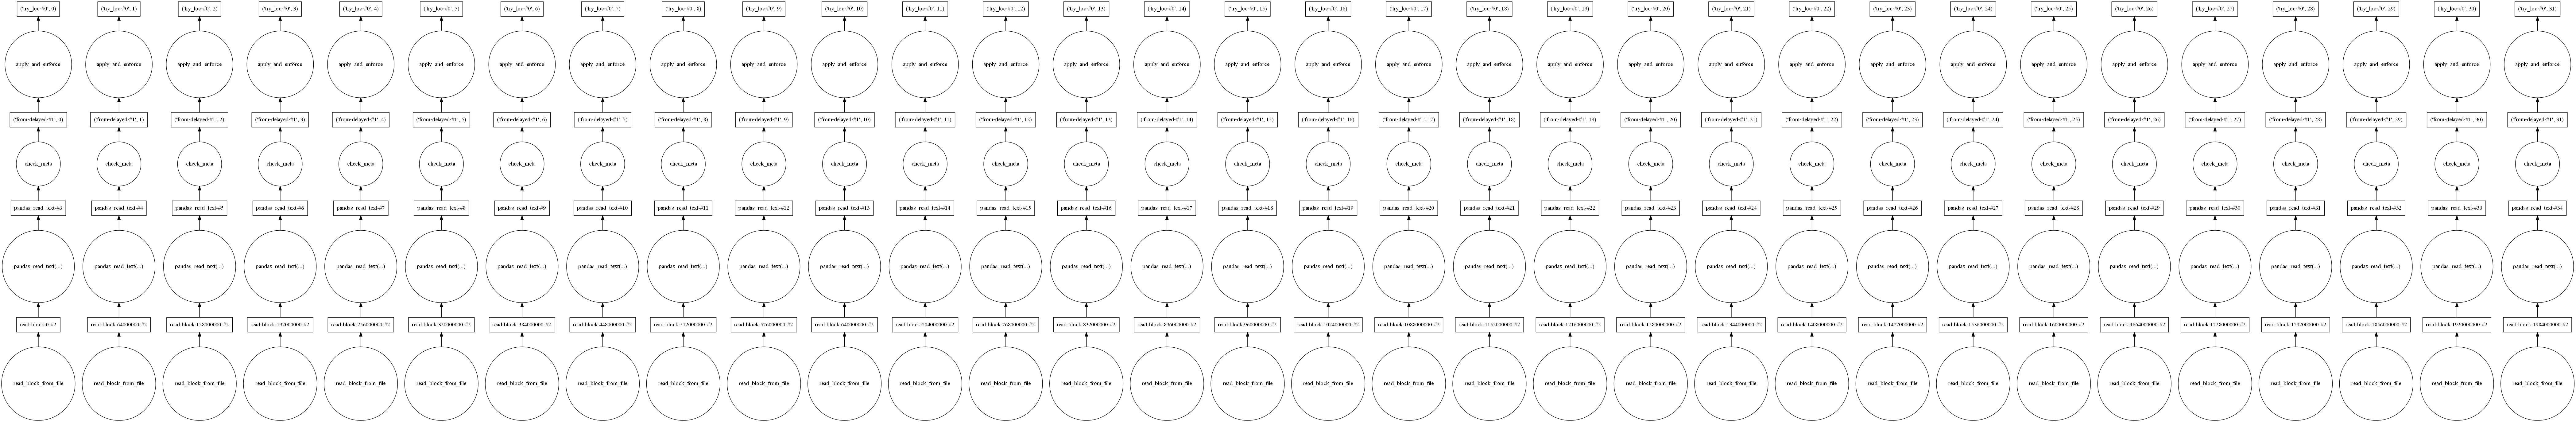

In [7]:
# However unlike pandas, operations on desk.dataframe doesn't trigger immediate computation
# instead they add key-value pairs to an underlying Desk graph, recall that in the diagram below
# circles are operations and rectangles are results

# to see the visulaization you need to install grraphviz

month2.visualize()

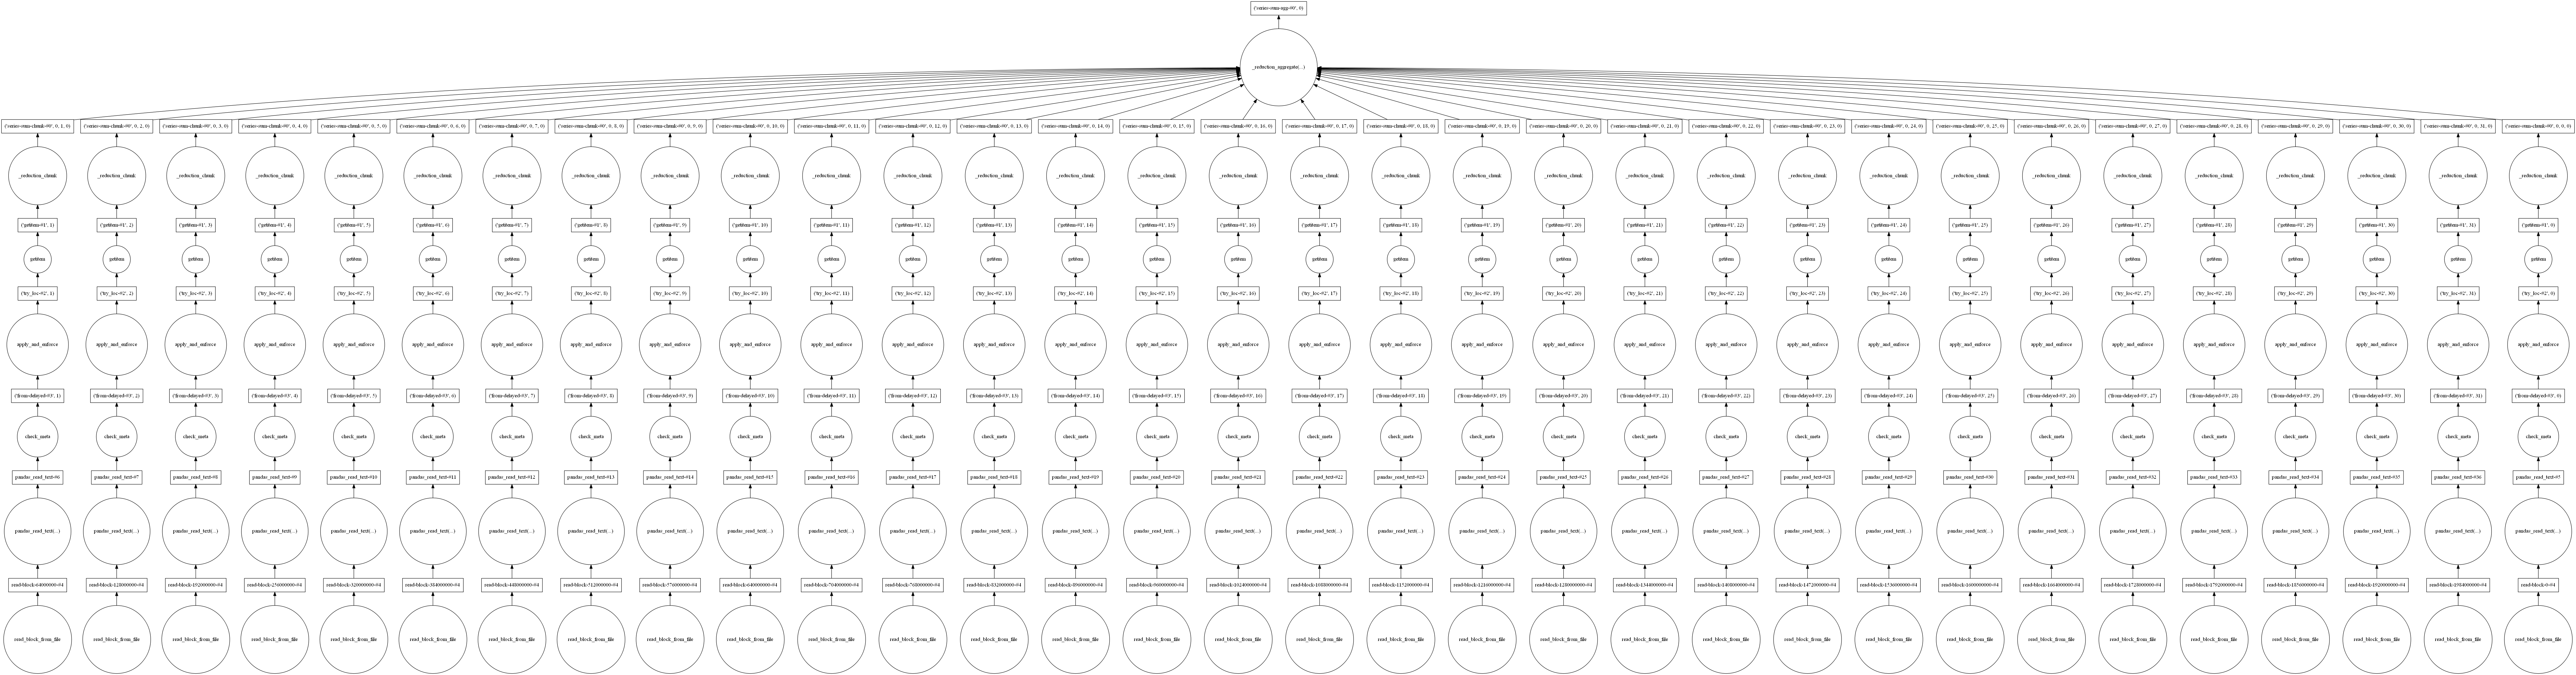

In [8]:
month2.fare_amount.sum().visualize()

# Data Cleaning
          in this section we will be doing univariate analysis and removing outliers/illegitimate values which may be coused
          due to some error

In [9]:
# table below shows few datapoints along with all our features
month2.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


# 1. Pickup latitude and pickup longitude:
    it is inferred from the source https://www.flickr.com/place/info/2459115 that NewYork is bounded by the location
    cordinates(lat, long) - (40.5774, -74.15) & (40.9176, -73.7004) so hence any cordinates not within these cordinates
    are not considered by us as we are only concerned with pickups which originates within NewYork.

In [10]:
# Plotting cordinates which are outside the bounding box of NewYork
# we will collect all the points outside the bounding box of NewYork city to outlier_locations

outlier_location =  month2[((month2.pickup_longitude <= -74.15) | (month2.pickup_latitude <= 40.5774) | (month2.pickup_longitude >= -73.7004)| (month2.pickup_latitude >= 40.9176 ) )]

# Creating a map with the base location using folium
# Note : you dont have to remember any of these, you dont need indeep knowledge on these maps

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only 100 outlier on the map, plotting all the outlier will take more time 
sample_location = outlier_location.head(10000)
for i, j in sample_location.iterrows():
    if int(j['pickup_latitude']) !=0:
        folium.Marker(list((j['pickup_latitude'], j['pickup_longitude']))).add_to(map_osm)

map_osm

Observation :- As you can see above that there are some point just outside the boundary but there are few either
               in South America, maxico or Canada 

# 2. Dropoff Latitude & Dropoff Longitude:
    it is inferred from the source https://www.flickr.com/place/info/2459115 that NewYork is bounded by the location
    cordinates(lat, long) - (40.5774, -74.15) & (40.9176, -73.7004) so hence any cordinates not within these cordinates
    are not considered by us as we are only concerned with pickups which originates within NewYork.

In [11]:
# Plotting cordinates which are outside the bounding box of NewYork
# we will collect all the points outside the bounding box of NewYork city to outlier_locations

outlier_location =  month2[((month2.dropoff_longitude <= -74.15) | (month2.dropoff_latitude <= 40.5774) | (month2.dropoff_longitude >= -73.7004)| (month2.dropoff_latitude >= 40.9176 ) )]

# Creating a map with the base location using folium
# Note : you dont have to remember any of these, you dont need indeep knowledge on these maps

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only 100 outlier on the map, plotting all the outlier will take more time 
sample_location = outlier_location.head(10000)
for i, j in sample_location.iterrows():
    if int(j['pickup_latitude']) !=0:
        folium.Marker(list((j['dropoff_latitude'], j['dropoff_longitude']))).add_to(map_osm)

map_osm

# 3. Trip Durations:
    According to NYC Taxi and Limousine Commision Regulations The maximum allowed trip duration in a 24 hours interval is 12 hrs.

In [12]:
#  the timestamps are converted to the unix so as to get duration (trip-time) & speed also pickup-times

# in out data we have time in the formnat "YYYY-MM-DD HH:MM:SS" we convert these string to python
# https://stackoverflow.com/a/27914405

def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

# We return the column which contains the columns
# 1. passenger_count : self explanatory
# 2. trip_distance : self explanatory
# 3. pickup_longitude : self explanatory
# 4. pickup_latitude : self explanatory
# 5. dropoff_longitude : self explanatory
# 6. dropoff_latitude : self explanatory
# 7. total_amount : total fair that was paid
# 8. trip_time : durations of each trip
# 9. pickup_time : pickup time converted to the unix time 
# 10. speed : velocity of each trip 


def return_with_trip_times(month2):
    duration = month2[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    
    # calculate duration of trips
    durations = (np.array(duration_drop)-np.array(duration_pickup))/float(60)
    
    #append duration of trips and speed in miles/hr to a new dataframe
    
    new_frame = month2[['passenger_count', 'trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(month2)
frame_with_durations.head()
    

TypeError: Column assignment doesn't support type ndarray

In [15]:
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    
    # calculate duration of trips
    durations = (np.array(duration_drop)-np.array(duration_pickup))/float(60)

In [16]:
duration = month2[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
print(duration)
print(duration_pickup)
print(duration_drop)
print(durations)


      tpep_pickup_datetime tpep_dropoff_datetime
0      2015-01-15 19:05:39   2015-01-15 19:23:42
1      2015-01-10 20:33:38   2015-01-10 20:53:28
2      2015-01-10 20:33:38   2015-01-10 20:43:41
3      2015-01-10 20:33:39   2015-01-10 20:35:31
4      2015-01-10 20:33:39   2015-01-10 20:52:58
5      2015-01-10 20:33:39   2015-01-10 20:53:52
6      2015-01-10 20:33:39   2015-01-10 20:58:31
7      2015-01-10 20:33:39   2015-01-10 20:42:20
8      2015-01-10 20:33:39   2015-01-10 21:11:35
9      2015-01-10 20:33:40   2015-01-10 20:40:44
10     2015-01-10 20:33:40   2015-01-10 20:41:39
11     2015-01-10 20:33:41   2015-01-10 20:43:26
12     2015-01-10 20:33:41   2015-01-10 20:35:23
13     2015-01-10 20:33:41   2015-01-10 21:03:04
14     2015-01-10 20:33:41   2015-01-10 20:39:23
15     2015-01-15 19:05:39   2015-01-15 19:32:00
16     2015-01-15 19:05:40   2015-01-15 19:21:00
17     2015-01-15 19:05:40   2015-01-15 19:28:18
18     2015-01-15 19:05:41   2015-01-15 19:20:36
19     2015-01-15 19

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [17]:
new_frame = month2[['passenger_count', 'trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]
new_frame['trip_times'] = durations
new_frame['pickup_times'] = duration_pickup
new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])

new_frame.head()


TypeError: Column assignment doesn't support type ndarray

In [ ]:
# The skewed boxplot shows us the presence of outliers

sns.boxplot(y= "trip_times", data = frame_with_durations)
plt.show()

In [ ]:
# Calculating 0 to 100 percentile to find a correct percentile value for removal of outliers
for i in range(0,100,10):
    var = frame_with_durations["trip_times"].values